<b>Βήμα 9:</b><br>
Στο βήμα αυτό χρησιμοποιήσαμε τη συνάρτηση που μας δόθηκε για να διαβάσουμε τα αρχεία από το dataset στο https://github.com/Jakobovski/free-spoken-digit-dataset. Αλλάξαμε στη γραμμή 11, την εντολή <b>f.split('/')[5]</b> από την <b>f.split('/')[1]</b>.

In [1]:
import numpy as np
import librosa
import os
from glob import glob

from sklearn.preprocessing import StandardScaler

def parser(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, '*.wav'))
    fnames = [f.split('/')[5].split('.')[0].split('_') for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        global Fs
        wav, fs = librosa.core.load(f, sr=None)
        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [librosa.feature.mfcc(wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=6).T for wav in wavs]
    # Print dataset info
    print('Total wavs: {}'.format(len(frames)))

    # Standardize data
    scaler = StandardScaler()
    scaler.fit(np.concatenate(frames))
    for i in range(len(frames)):
        frames[i] = scaler.transform(frames[i])

    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ['0', '1', '2', '3', '4']
    for idx, frame, label, spk in zip(ids, frames, y, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test

In [2]:
# Reading the wavs with given parser.py function
(X_train_set, X_test_set, y_train_set, y_test_set, spk_train, spk_test) = parser("/home/manzar/Desktop/recordings/")

Total wavs: 1500


Τώρα θα χωρίσουμε το dataset σε train και test δεδομενα ώστε το split να είναι <b>stratified</b>.

In [3]:
from sklearn.model_selection import train_test_split

# Split the test set
X_train, X_val, y_train, y_val = train_test_split(X_train_set, y_train_set, stratify=y_train_set, test_size=0.2)


In [6]:
from pomegranate import *


def create_GMM_HMM_models(X,Y,No_states,No_mixtures):
    my_GMMHMM_models=[]

    #se auti tin ilopioisi pernw ola ta idia psifia kai ta kanw afou prwta parw ta means tous meta ta kanw concatenate

    
    
    #se auti tin ilopioisi pernw ola ta idia psifia kai ta kanw concatenate
    for d in range(0,10):
        data_features=[]
        k=0
        for index,data in enumerate(Y):
            if data==d:
                if k==0:
                    concatenated_features = X[index] #create for each digit an array with the features of each window concatenated in vertical axis.
                    k+=1
                else:
                    concatenated_features = np.concatenate((concatenated_features,X[index]),axis=0)
                data_features.append(X[index].tolist())
                
        
        print(d)
        #print(concatenated_features.shape)
        #print(len(data_features[0][0]))
       
        
        
            
        dists = [] # list of probability distributions for the HMM states
        n_states = No_states# the number of HMM states
        n_mixtures = No_mixtures # the number of Gaussians
        gmm = True # whether to use GMM or plain Gaussian


        for i in range(n_states):
            if gmm:
                a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, concatenated_features)
            else:
                a = MultivariateGaussianDistribution.from_samples(concatenated_features)
            dists.append(a)

        #initialize transition matrix
        trans_mat = np.zeros([n_states,n_states]) # your transition matrix

        for i in range(0,n_states):
            if i==n_states-1:
                trans_mat[i][i]=1    
            else:
                trans_mat[i][i]=0.5
                trans_mat[i][i+1]=0.5

        #print(trans_mat)
        #initialize start prob matrix and end prob matrix
        starts = [1]+[0]*(n_states-1)
        ends = [0]*(n_states-1)+[1]
        
        #print(trans_mat)
        #print(starts)
        #print(ends)
        #transition_mat = np.asarray(transition_mat) # your transition matrix
        #starts = np.asarray(starts) # your starting probability matrix
        #ends = np.asarray(ends)  # your ending probability matrix


        
        data = data_features # your data: must be a Python list that contains: 2D lists with the sequences (so its dimension would be num_sequences x seq_length x feature_dimension)
                  # But be careful, it is not a numpy array, it is a Python list (so each sequence can have different length)


        # Define the GMM-HMM
        model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(n_states)])

        # Fit the model
        model.fit(data_features,max_iterations=5)

        #print(model)
        my_GMMHMM_models.append(model)
        
    return my_GMMHMM_models
        


Επιλέγουμε 2 gaussian mixture models και 4 hidden states

In [7]:
models=create_GMM_HMM_models(X_train,y_train,4,2)

0
1
2
3
4
5
6
7
8
9


In [8]:
# Predict a sequence
sample = X_val[1] # a sample sequence

log_probs = []

for model in models:
    logp, _ = model.viterbi(sample) # Run viterbi algorithm and return log-probability
    log_probs.append(logp)
    
    
digit_pred=np.argmax(log_probs)
print(digit_pred)
print(y_val[1])


5
5


vima 13: ipologismos confussion matrix gia validation set kai test set kai antistoixwn accuracy!

0.9629629629629629
Confusion matrix, without normalization
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 27  0  0  0  0  0  0  0  0]
 [ 1  0 26  0  0  0  0  0  0  0]
 [ 0  0  1 25  0  0  0  0  1  0]
 [ 0  0  0  0 27  0  0  0  0  0]
 [ 0  1  0  0  0 24  0  1  0  1]
 [ 0  0  0  0  0  0 27  0  0  0]
 [ 0  0  0  0  0  0  0 27  0  0]
 [ 0  0  0  1  0  0  1  1 24  0]
 [ 0  1  0  0  0  0  0  0  0 26]]


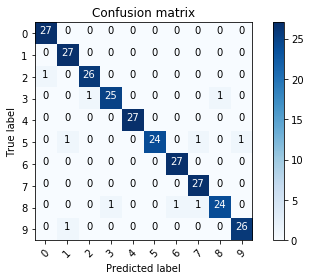

In [12]:
confusion_val=np.zeros([len(np.unique(y_val)),len(np.unique(y_val))])
accuracy_val=0;

for sample,label in zip(X_val,y_val):
    
    log_probs=[]
    for model in models:
        
        logp, _ = model.viterbi(sample) # Run viterbi algorithm and return log-probability
        log_probs.append(logp)
    digit_pred=np.argmax(log_probs)
    confusion_val[label][digit_pred] +=1
    if label==digit_pred:
        accuracy_val+=1
#print(confusion_val)
accuracy_val = accuracy_val / len(X_val)
print(accuracy_val)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(confusion_val.astype(int),[0,1,2,3,4,5,6,7,8,9])


0.9733333333333334
Confusion matrix, without normalization
[[15  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  1  0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0]
 [ 0  0  0  2  0  0  1  0 12  0]
 [ 0  0  0  0  0  0  0  0  0 15]]


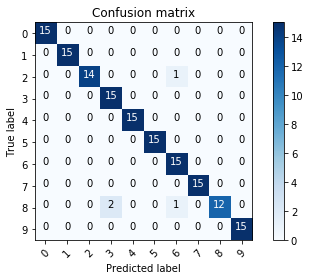

In [13]:


confusion_test=np.zeros([len(np.unique(y_test_set)),len(np.unique(y_test_set))])
accuracy_test=0;

for sample,label in zip(X_test_set,y_test_set):
    log_probs=[]
    for model in models:
        logp, _ = model.viterbi(sample) # Run viterbi algorithm and return log-probability
        log_probs.append(logp)
    digit_pred=np.argmax(log_probs)
    confusion_test[label][digit_pred] +=1
    if label==digit_pred:
        accuracy_test+=1

accuracy_test = accuracy_test / len(X_test_set)

print(accuracy_test)

import numpy as np
import itertools
import matplotlib.pyplot as plt

plot_confusion_matrix(confusion_test.astype(int),[0,1,2,3,4,5,6,7,8,9])

Βήμα 14:
Σε αυτό το βήμα υλοποιούμε ένα baseline lstm.. και στην συνέχεια κάνουμε διάφορες παραλλαγές αυτού.

In [22]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        #store length of each element sequence
        self.lengths =  [element.shape[0] for element in feats]

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('int64')
            

    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        padded = []
        # --------------- Insert your code here ---------------- #
        max_sequence_length = max(self.lengths)
        for index,instance in enumerate(x):
            if self.lengths[index] < max_sequence_length:
                zero_features = np.zeros( (max_sequence_length-self.lengths[index], instance.shape[1]))
                padded.append(np.concatenate((instance,zero_features),axis=0))
            else:
                padded.append(instance)
        padded = np.asarray(padded)
        return padded
    

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]
    

    def __len__(self):
        return len(self.feats)
    
from torch.autograd import Variable
class Variational_LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, features, dropout=0.5):
        if not self.training or not dropout:
            return features
        else:
            m = features.data.new(features.size(0), 1, features.size(2)).bernoulli(1-dropout)
            print(m.shape)
            #we have make mask for all instances in batch and for each feature input vector. Now, we have to apply
            #the same mask in each time-step (same mask in the whole sequnce).So we extend the mask matrix
            #to all time-steps.
            mask = Variable(m, requires_grad=False) / (1 - dropout)
            #Extend mask matrix to be the same for each time-step.
            mask = mask.expand_as(features)
            #we can check that for 2 different time-steps(for specific instance and input) we have the same masks. 
            print(mask[0][1])
            print(mask[0][152])
            return mask*features

class BasicLSTM(nn.Module):
    def __init__(self, input_dim,rnn_size, output_dim, num_layers,dropout_type=None,dropout=0, bidirectional=False):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.dropout=dropout
        '''
        if dropout_type is not None:
            if dropout_type = 'Variational_Locked_Dropout'
            self.dropout = Variational_LockedDropout(dropout=dropout_prob)
        '''
            
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        
        
        #for non-bidirectional:
        #we assume that rnn-size is the number of lstm-units...
        #input_dim is the vector that each unit will receive as input..
        #hidden_dim at basic lstm is the same as hidden_dim...
        #so we have...
        self.num_layers=num_layers
        self.hidden_dim = rnn_size # OR self.hidden_dim = self.feature_size
        if self.bidirectional:
            self.lstm = nn.LSTM(input_dim,self.hidden_dim//2,num_layers=num_layers,bidirectional=bidirectional,
                                dropout=self.dropout,batch_first=True)
        else:
            self.lstm = nn.LSTM(input_dim,self.hidden_dim,num_layers=num_layers,bidirectional=bidirectional,
                                dropout=self.dropout,batch_first=True)

        #using batch_first=True affects only the input!
        # if the input is at form seq_len,batch,features batch_first=True is not needed
        
        #self.hidden = self.init_hidden() #initialize hidden state(and cell state)
        
        #use a linear transformation from lstm hidden_state space to ouput space..
        #for digit classification we want to classify a sequence to 0-9 digits. So we will use as output dim the number 10.
        self.output_set_size = output_dim
        self.hidden2output = nn.Linear(self.hidden_dim,self.output_set_size)

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network 
        lstm_out,_ = self.lstm(x)
        last_lstm_out = self.last_timestep(lstm_out,lengths)   
        out_space = self.hidden2output(last_lstm_out)
        return out_space

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if self.bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [23]:
samples=[elem for elem in X_train] 
train=FrameLevelDataset(samples,y_train)


samples=[elem for elem in X_val] 
val=FrameLevelDataset(samples,y_val)

samples=[elem for elem in X_test_set] 
test=FrameLevelDataset(samples,y_test_set)


In [24]:
from torch.utils.data import DataLoader

BATCH_SZ=16

train_batches = DataLoader(train,batch_size=BATCH_SZ,shuffle=True,num_workers=4)
val_batches = DataLoader(val,batch_size=BATCH_SZ,shuffle=True,num_workers=4)
test_batches = DataLoader(test,batch_size=BATCH_SZ,shuffle=True,num_workers=4)


In [26]:
INPUT_SZ=6
NUM_CLASSES=10
NUM_LAYERS=1
HIDDEN_SIZE=20



Ekpaideusi kai tautoxrona apotimisi sto validation set!

In [27]:
model=BasicLSTM(INPUT_SZ,HIDDEN_SIZE,NUM_CLASSES,NUM_LAYERS,bidirectional=False)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

EPOCHS=35

for epoch in range(EPOCHS):
    #no need to set requires_grad=True for parameters(weights) as it done by default. Also for input requires_grad is not
    #always necessary. So we comment the following line.
    #with torch.autograd(): 
    model.train()
    scheduler.step()
    running_average_loss = 0

    #train model in each epoch
    for index,instance in enumerate(train_batches):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        features,labels,lengths=instance     
        features = features.type(torch.FloatTensor)
     

        optimizer.zero_grad()
        
        # Step 3. Run our forward pass.
        prediction_vec = model(features,lengths)
        #print(prediction_vec.shape)
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(prediction_vec,labels)
        loss.backward(retain_graph=True)
        optimizer.step()

        running_average_loss += loss.detach().item()
    print("Epoch: {} \t \t Training Loss {}".format(epoch, float(running_average_loss) / (index + 1)))

    #we set torch no grad for deactivating autograd engine as we are in evaluation mode and there is no need of computing
    # gradients...(It will reduce memory usage and speed up computations but we won’t be able to backpropagate! )
    #In evaluation we dont backprop!
    with torch.no_grad():
        #model.eval() will notify all our layers that we are in eval mode, that way, batchnorm or dropout layers will work
        #in eval mode instead of training mode! (dropout will be set to 0 as we dont want to deactivate units during eval)
        model.eval()

        # evaluate model in each epoch
        running_average_loss = 0
        acc = 0
        n_samples = 0
        for index, instance in enumerate(val_batches):

            features, labels ,lengths = instance
            features = features.type(torch.FloatTensor)
            out = model(features,lengths)
            loss = loss_function(out,labels)

            running_average_loss += loss.detach().item()
            
        print("Epoch: {} \t  \t Validation Loss {}".format(epoch, float(running_average_loss) / (index + 1)))



Epoch: 0 	 	 Training Loss 2.2332704803522896
Epoch: 0 	  	 Validation Loss 2.1471177129184498
Epoch: 1 	 	 Training Loss 1.981798817129696
Epoch: 1 	  	 Validation Loss 1.809194522745469
Epoch: 2 	 	 Training Loss 1.6263350826852463
Epoch: 2 	  	 Validation Loss 1.5217591944862814
Epoch: 3 	 	 Training Loss 1.3819452015792622
Epoch: 3 	  	 Validation Loss 1.2923992311253267
Epoch: 4 	 	 Training Loss 1.2144383902058882
Epoch: 4 	  	 Validation Loss 1.1661964409491594
Epoch: 5 	 	 Training Loss 1.0818723115850897
Epoch: 5 	  	 Validation Loss 1.0301334086586447
Epoch: 6 	 	 Training Loss 0.9763844539137447
Epoch: 6 	  	 Validation Loss 0.9601730108261108
Epoch: 7 	 	 Training Loss 0.8726866118171636
Epoch: 7 	  	 Validation Loss 0.9623648454161251
Epoch: 8 	 	 Training Loss 0.785246771048097
Epoch: 8 	  	 Validation Loss 0.7189336138613084
Epoch: 9 	 	 Training Loss 0.6899191649521098
Epoch: 9 	  	 Validation Loss 0.6796991509549758
Epoch: 10 	 	 Training Loss 0.6146121467737591
Epoch:

Συνολική αποτίμηση στο test.

In [28]:
model.eval()
acc = 0
n_samples = 0
with torch.no_grad():
    for index, batch in enumerate(test_batches):
        instances, labels ,lengths = batch
        instances = instances.type(torch.FloatTensor)
        out = model(instances,lengths)
        out_scores = F.log_softmax(out,dim=1)
        value, y_pred = out_scores.max(1)
        
        acc += (labels == y_pred).sum().detach().item()
        n_samples += instances.shape[0]

print("Score for validation set: " ,acc / n_samples)

Score for validation set:  0.92


Σε αυτό το βήμα υλοποιούμε early stopping και checkpoints και στο επόμενο θα δοκιμάσουμε διάφορα μοντέλα με χρήση dropout,L2 regularization kai biderectional lstm.Χρησιμοποιούμε early stopping και checkpoints για να γλυτώσουμε χρονο κατα την εκπαίδευση και για να αποφύγουμε overfitting. Τα checkpoints κρατάνε προηγούμενες καταστάσεις του μοντέλου μου τις οποίες μπορουμε να φορτώσουμε.

In [30]:


class Trainer_with_Checkpoints():
    def __init__(self,validate_every,metrics,max_epochs,patience=10):
    
        self.validate_every=validate_every
        self.metrics = metrics
        self.patience=patience
        self.best_score=None
        self.max_epochs = max_epochs
        
        
    def validate_accuracy(self,mymodel,validation_batches):
        with torch.no_grad():
            mymodel.eval()
            num_correct=0
            num_samples=0
            with torch.no_grad():
                for index, instance in enumerate(validation_batches):
                    features, labels ,lengths = instance
                    features = features.type(torch.FloatTensor)
                    #mymodel.hidden = mymodel.init_hidden(features.shape[0])
                    out = mymodel(features,lengths)
                    out_scores = F.log_softmax(out,dim=1)
                    value, y_pred = out_scores.max(1)

                    num_correct += (labels == y_pred).sum().detach().item()
                    num_samples += features.shape[0]

                print("Score for validation set: " ,num_correct / num_samples)
        return num_correct/num_samples

    
    def checkpoint(self,mymodel,myoptimizer,epoch,checkpointdir,myscheduler=None):
        
        #if myscheduler is not None:
         #   state = {'epoch': epoch + 1,'state_dict': mymodel.state_dict(),
       #              'optim_dict' : myoptimizer.state_dict(),'scheduler_dict' : myscheduler.state_dict()}
        #else:
        #    state = {'epoch': epoch + 1,'state_dict': mymodel.state_dict(),'optim_dict' : myoptimizer.state_dict()}
        
        #utils.save_checkpoint(state,checkpoint=self.checkpointdir) # path to folder
        torch.save({
            'epoch': epoch,
            'model_state_dict': mymodel.state_dict(),
            'optimizer_state_dict': myoptimizer.state_dict(),
            'scheduler_state_dict': myscheduler.state_dict(),
            }, checkpointdir)
        return
    
    
    def train_model(self,mymodel,myoptimizer,myloss_function,training_batches,validation_batches,
                    checkpointdir,myscheduler=None):
        
        self.best_score=None
        counter =0

        if self.patience < 1:
            raise ValueError("Argument patience should be positive integer")
        
        
        
        for epoch in range(self.max_epochs):
            #no need to set requires_grad=True for parameters(weights) as it done by default. Also for input requires_grad is not
            #always necessary. So we comment the following line.
            #with torch.autograd(): 
            mymodel.train()

            if myscheduler is not None:
                myscheduler.step()

            running_average_loss = 0


            #train model in each epoch
            for index,instance in enumerate(training_batches):
                # Step 1. Remember that Pytorch accumulates gradients.
                # We need to clear them out before each instance
                features,labels,lengths=instance     
                features = features.type(torch.FloatTensor)
                myoptimizer.zero_grad()
                prediction_vec = mymodel(features,lengths)
                myloss = myloss_function(prediction_vec,labels)
                myloss.backward(retain_graph=True)
                myoptimizer.step()
                running_average_loss += myloss.detach().item()
                if index % 50 == 0:
                    print("Epoch: {} \t Batch: {} \t Training Loss {}".format(epoch, index, float(running_average_loss) / (index + 1)))
               
            if epoch==self.max_epochs-1:
                print("yyyyyeaaaaahhhh")
                if 'accuracy' in self.metrics:
                    score = self.validate_accuracy(mymodel,validation_batches)

                if self.best_score is None:
                    self.best_score = score
                    self.checkpoint(mymodel,myoptimizer,epoch,checkpointdir,myscheduler)
                    print("checkpoint done!")
                    
                elif score < self.best_score:
                    counter += 1
                    if counter >= self.patience:
                        print("EarlyStopping: Stop training")
                        return
                else:
                    #found better state in our model
                    self.best_score = score
                    counter = 0
                    #checkpoint
                    self.checkpoint(mymodel,myoptimizer,epoch,checkpointdir,myscheduler)
                    print("checkpoint done!")
            
            if epoch % self.validate_every == 0:
                if 'accuracy' in self.metrics:
                    score = self.validate_accuracy(mymodel,validation_batches)

                if self.best_score is None:
                    self.best_score = score
                    #checkpoint
                    self.checkpoint(mymodel,myoptimizer,epoch,checkpointdir,myscheduler)
                    print("checkpoint done!")
                    
                elif score < self.best_score:
                    counter += 1
                    if counter >= self.patience:
                        print("EarlyStopping: Stop training")
                        return
                    
                else:
                    #found better state in our model
                    self.best_score = score
                    counter = 0
                    #checkpoint
                    self.checkpoint(mymodel,myoptimizer,epoch,checkpointdir,myscheduler)
                    print("checkpoint done!")
        
               



In [31]:
VALIDATE_EVERY=5
METRICS='accuracy'
MAX_EPOCHS=60
PATIENCE=3
INPUT_SZ=6
NUM_CLASSES=10
NUM_LAYERS=1
HIDDEN_SIZE=20

CHECKDIR='/home/manzar/Desktop/examino9/protipa/lab2/patrec/lab_2/checkpoints/model1.pt'
model=BasicLSTM(INPUT_SZ,HIDDEN_SIZE,NUM_CLASSES,NUM_LAYERS,bidirectional=False)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


trainer = Trainer_with_Checkpoints(validate_every=VALIDATE_EVERY,metrics=METRICS,max_epochs=MAX_EPOCHS,patience=PATIENCE)

trainer.train_model(mymodel=model,myoptimizer=optimizer,myloss_function=loss_function,training_batches=train_batches,
                    validation_batches=val_batches,checkpointdir=CHECKDIR,myscheduler=scheduler)

Epoch: 0 	 Batch: 0 	 Training Loss 2.2479171752929688
Epoch: 0 	 Batch: 50 	 Training Loss 2.2642657803554163
Score for validation set:  0.26666666666666666
checkpoint done!
Epoch: 1 	 Batch: 0 	 Training Loss 2.153886318206787
Epoch: 1 	 Batch: 50 	 Training Loss 2.0857058225893508
Epoch: 2 	 Batch: 0 	 Training Loss 1.9879462718963623
Epoch: 2 	 Batch: 50 	 Training Loss 1.8181033414952896
Epoch: 3 	 Batch: 0 	 Training Loss 1.7510266304016113
Epoch: 3 	 Batch: 50 	 Training Loss 1.5337430238723755
Epoch: 4 	 Batch: 0 	 Training Loss 1.5207887887954712
Epoch: 4 	 Batch: 50 	 Training Loss 1.3249897933473773
Epoch: 5 	 Batch: 0 	 Training Loss 1.1543538570404053
Epoch: 5 	 Batch: 50 	 Training Loss 1.155113027376287
Score for validation set:  0.48518518518518516
checkpoint done!
Epoch: 6 	 Batch: 0 	 Training Loss 1.3605644702911377
Epoch: 6 	 Batch: 50 	 Training Loss 1.072583870560515
Epoch: 7 	 Batch: 0 	 Training Loss 0.9405754804611206
Epoch: 7 	 Batch: 50 	 Training Loss 0.9536

Παρακάτω εφαρμόζουμε τις ζητούμενες τεχνικές. Ωστόσο δεν προλάβαμε να τις τρέξουμε για την αναφορά. Παρακαλούμε τρέξτε τις.Έχουν δοκιμαστεί προηγουμένως.

In [ ]:
checkpoint = torch.load(CHECKDIR)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

model.eval()
acc = 0
n_samples = 0
with torch.no_grad():
    for index, batch in enumerate(test_batches):
        instances, labels ,lengths = batch
        instances = instances.type(torch.FloatTensor)
        out = model(instances,lengths)
        out_scores = F.log_softmax(out,dim=1)
        value, y_pred = out_scores.max(1)
        
        acc += (labels == y_pred).sum().detach().item()
        n_samples += instances.shape[0]

print("Score for validation set: " ,acc / n_samples)

In [ ]:
VALIDATE_EVERY=5
METRICS='accuracy'
MAX_EPOCHS=60
PATIENCE=3
INPUT_SZ=6
NUM_CLASSES=10
NUM_LAYERS=1
HIDDEN_SIZE=20

CHECKDIR='/home/manzar/Desktop/examino9/protipa/lab2/patrec/lab_2/checkpoints/model2_bidir.pt'
model=BasicLSTM(INPUT_SZ,HIDDEN_SIZE,NUM_CLASSES,NUM_LAYERS,bidirectional=True)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


trainer.train_model(mymodel=model,myoptimizer=optimizer,myloss_function=loss_function,training_batches=train_batches,
                    validation_batches=val_batches,checkpointdir=CHECKDIR,myscheduler=scheduler)

In [ ]:
checkpoint = torch.load('/home/manzar/Desktop/examino9/protipa/lab2/patrec/lab_2/checkpoints/model2_bidir.pt')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

model.eval()
acc = 0
n_samples = 0
with torch.no_grad():
    for index, batch in enumerate(test_batches):
        instances, labels ,lengths = batch
        instances = instances.type(torch.FloatTensor)
        out = model(instances,lengths)
        out_scores = F.log_softmax(out,dim=1)
        value, y_pred = out_scores.max(1)
        
        acc += (labels == y_pred).sum().detach().item()
        n_samples += instances.shape[0]

print("Score for validation set: " ,acc / n_samples)

In [ ]:
VALIDATE_EVERY=5
METRICS='accuracy'
MAX_EPOCHS=60
PATIENCE=3

INPUT_SZ=6
NUM_CLASSES=10
NUM_LAYERS=2
HIDDEN_SIZE=20

CHECKDIR='/home/manzar/Desktop/examino9/protipa/lab2/patrec/lab_2/checkpoints/model3_.pt'
model = BasicLSTM(INPUT_SZ,HIDDEN_SIZE,NUM_CLASSES,NUM_LAYERS,dropout=0.4,bidirectional=False)
loss_function  = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1,weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)



trainer.train_model(mymodel=model,myoptimizer=optimizer,myloss_function=loss_function,training_batches=train_batches,
                    validation_batches=val_batches,checkpointdir=CHECKDIR,myscheduler=scheduler)

In [ ]:
checkpoint = torch.load('/home/manzar/Desktop/examino9/protipa/lab2/patrec/lab_2/checkpoints/model3_.pt')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

model.eval()
acc = 0
n_samples = 0
with torch.no_grad():
    for index, batch in enumerate(test_batches):
        instances, labels ,lengths = batch
        instances = instances.type(torch.FloatTensor)
        out = model(instances,lengths)
        out_scores = F.log_softmax(out,dim=1)
        value, y_pred = out_scores.max(1)
        
        acc += (labels == y_pred).sum().detach().item()
        n_samples += instances.shape[0]

print("Score for validation set: " ,acc / n_samples)

In [ ]:
VALIDATE_EVERY=5
METRICS='accuracy'
MAX_EPOCHS=60
PATIENCE=3

INPUT_SZ=6
NUM_CLASSES=10
NUM_LAYERS=2
HIDDEN_SIZE=20

CHECKDIR='/home/manzar/Desktop/examino9/protipa/lab2/patrec/lab_2/checkpoints/model4_.pt'
model = BasicLSTM(INPUT_SZ,HIDDEN_SIZE,NUM_CLASSES,NUM_LAYERS,bidirectional=True)
loss_function  = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)



trainer.train_model(mymodel=model,myoptimizer=optimizer,myloss_function=loss_function,training_batches=train_batches,
                    validation_batches=val_batches,checkpointdir=CHECKDIR,myscheduler=scheduler)

In [ ]:
checkpoint = torch.load('/home/manzar/Desktop/examino9/protipa/lab2/patrec/lab_2/checkpoints/model4_.pt')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

model.eval()
acc = 0
n_samples = 0
with torch.no_grad():
    for index, batch in enumerate(test_batches):
        instances, labels ,lengths = batch
        instances = instances.type(torch.FloatTensor)
        out = model(instances,lengths)
        out_scores = F.log_softmax(out,dim=1)
        value, y_pred = out_scores.max(1)
        
        acc += (labels == y_pred).sum().detach().item()
        n_samples += instances.shape[0]

print("Score for validation set: " ,acc / n_samples)

Υλοποίηση με packed padded sequence

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        #store length of each element sequence
        self.lengths =  [element.shape[0] for element in feats]

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('int64')
            

    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        padded = []
        # --------------- Insert your code here ---------------- #
        max_sequence_length = max(self.lengths)
        for index,instance in enumerate(x):
            if self.lengths[index] < max_sequence_length:
                zero_features = np.zeros( (max_sequence_length-self.lengths[index], instance.shape[1]))
                padded.append(np.concatenate((instance,zero_features),axis=0))
            else:
                padded.append(instance)
        padded = np.asarray(padded)
        return padded
    

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]
    

    def __len__(self):
        return len(self.feats)
    
from torch.autograd import Variable


class BasicLSTM(nn.Module):
    def __init__(self, input_dim,rnn_size, output_dim, num_layers,dropout_type=None,dropout=0, bidirectional=False):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        #self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.dropout=dropout
        '''
        if dropout_type is not None:
            if dropout_type = 'Variational_Locked_Dropout'
            self.dropout = Variational_LockedDropout(dropout=dropout_prob)
        '''
            
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        
        
        #for non-bidirectional:
        #we assume that rnn-size is the number of lstm-units...
        #input_dim is the vector that each unit will receive as input..
        #hidden_dim at basic lstm is the same as hidden_dim...
        #so we have...
        self.num_layers=num_layers
        self.hidden_dim = rnn_size # OR self.hidden_dim = self.feature_size
        if self.bidirectional:
            self.lstm = nn.LSTM(input_dim,self.hidden_dim//2,num_layers=num_layers,bidirectional=bidirectional,
                                dropout=self.dropout,batch_first=True)
        else:
            self.lstm = nn.LSTM(input_dim,self.hidden_dim,num_layers=num_layers,bidirectional=bidirectional,
                                dropout=self.dropout,batch_first=True)

        #using batch_first=True affects only the input!
        # if the input is at form seq_len,batch,features batch_first=True is not needed
        
        #self.hidden = self.init_hidden() #initialize hidden state(and cell state)
        
        #use a linear transformation from lstm hidden_state space to ouput space..
        #for digit classification we want to classify a sequence to 0-9 digits. So we will use as output dim the number 10.
        self.output_set_size = output_dim
        self.hidden2output = nn.Linear(self.hidden_dim,self.output_set_size)

    def forward(self,x,lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network 
        packedinput = pack_padded_sequence(x, lengths, batch_first=True)
        packed_output,_ = self.lstm(packedinput)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output2 = self.last_timestep(output,lengths)
        out_space = self.hidden2output(output2)
        return out_space

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if self.bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [ ]:
samples=[elem for elem in X_train] 
train=FrameLevelDataset(samples,y_train)


samples=[elem for elem in X_val] 
val=FrameLevelDataset(samples,y_val)

samples=[elem for elem in X_test_set] 
test=FrameLevelDataset(samples,y_test_set)



In [ ]:
from torch.utils.data import DataLoader

BATCH_SZ=16

train_batches = DataLoader(train,batch_size=BATCH_SZ,shuffle=True,num_workers=4)
val_batches = DataLoader(val,batch_size=BATCH_SZ,shuffle=True,num_workers=4)
test_batches = DataLoader(test,batch_size=BATCH_SZ,shuffle=True,num_workers=4)

INPUT_SZ=6
NUM_CLASSES=10
NUM_LAYERS=1
HIDDEN_SIZE=20

In [ ]:


loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
model=BasicLSTM(INPUT_SZ,HIDDEN_SIZE,NUM_CLASSES,NUM_LAYERS,bidirectional=True)
EPOCHS=35
model.train()


for epoch in range(EPOCHS):  
    scheduler.step()
    running_average_loss = 0

    for index,instance in enumerate(train_batches):

        features,labels,lengths_b=instance     
        features = features.type(torch.FloatTensor)
     
        orders=np.argsort(-lengths_b)
        sorted_lengths = lengths_b[orders]
        sorted_labels = labels[orders]
        sorted_feats = features[orders]
        model.zero_grad()
        

        prediction_vec = model(sorted_feats,sorted_lengths)
        loss = loss_function(prediction_vec,labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        running_average_loss += loss.detach().item()
    print("Epoch: {} \t \t Training Loss {}".format(epoch, float(running_average_loss) / (index + 1)))

